In [10]:
import tensorflow as tf

# Import TensorFlow Datasets
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

# Helper libraries
import math
import numpy as np
import matplotlib.pyplot as plt

import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)
import pandas as pd

In [2]:
dataset, metadata = tfds.load('fashion_mnist', as_supervised=True, with_info=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

2022-12-27 11:10:57.036044: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal',      'Shirt',   'Sneaker',  'Bag',   'Ankle boot']

In [4]:
num_train_examples = metadata.splits['train'].num_examples
num_test_examples = metadata.splits['test'].num_examples
print("Number of training examples: {}".format(num_train_examples))
print("Number of test examples:     {}".format(num_test_examples))

Number of training examples: 60000
Number of test examples:     10000


In [5]:
def normalize(images, labels):
  images = tf.cast(images, tf.float32)
  images /= 255
  return images, labels

# The map function applies the normalize function to each element in the train
# and test datasets
train_dataset =  train_dataset.map(normalize)
test_dataset  =  test_dataset.map(normalize)

# The first time you use the dataset, the images will be loaded from disk
# Caching will keep them in memory, making training faster
train_dataset =  train_dataset.cache()
test_dataset  =  test_dataset.cache()

2022-12-27 11:10:57.343386: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2022-12-27 11:10:57.343517: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


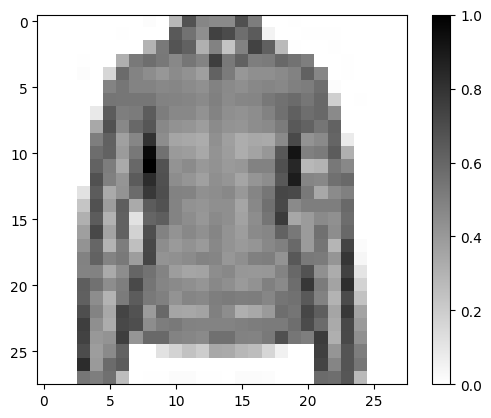

In [6]:
# Take a single image, and remove the color dimension by reshaping
for image, label in test_dataset.take(1):
  break
image = image.numpy().reshape((28,28))

# Plot the image - voila a piece of fashion clothing
plt.figure()
plt.imshow(image, cmap=plt.cm.binary)
plt.colorbar()
plt.grid(False)
plt.show()

2022-12-27 11:10:58.015108: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2022-12-27 11:10:58.015297: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


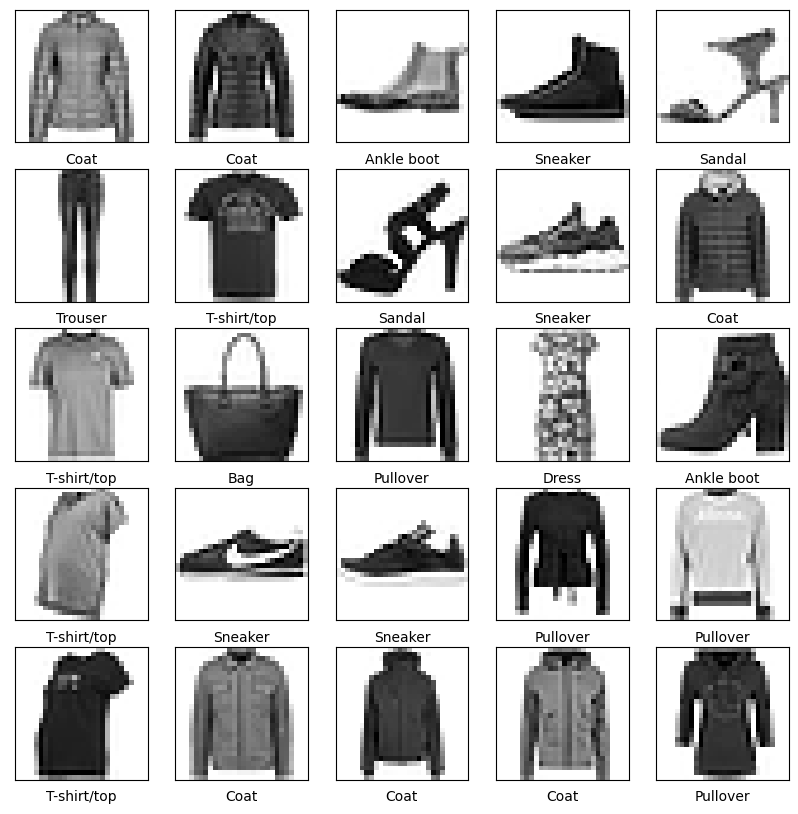

In [7]:
plt.figure(figsize=(10,10))
i = 0
for (image, label) in test_dataset.take(25):
    image = image.numpy().reshape((28,28))
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(image, cmap=plt.cm.binary)
    plt.xlabel(class_names[label])
    i += 1
plt.show()

In [13]:
def build_model(number_of_neurons=128, number_of_layers=1):
    
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, (3,3), padding='same', activation=tf.nn.relu,
                               input_shape=(28, 28, 1)),
        tf.keras.layers.MaxPooling2D((2, 2), strides=2),
        tf.keras.layers.Conv2D(64, (3,3), padding='same', activation=tf.nn.relu),
        tf.keras.layers.MaxPooling2D((2, 2), strides=2),
        ])
    model.add(tf.keras.layers.Flatten(input_shape=(28, 28, 1)))

    for i in range(number_of_layers):
        model.add(tf.keras.layers.Dense(number_of_neurons, activation=tf.nn.relu))
        model.add(tf.keras.layers.Dropout(0.2))

    model.add(tf.keras.layers.Dense(10, activation=tf.nn.softmax))

    model.compile(optimizer='adam',
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                  metrics=['accuracy'])
    return model

def train(model, train_dataset, num_train_examples, test_dataset, num_test_examples):
    BATCH_SIZE = 32
    train_dataset = train_dataset.cache().repeat().shuffle(num_train_examples).batch(BATCH_SIZE)
    test_dataset = test_dataset.cache().batch(BATCH_SIZE)

    model.fit(train_dataset, epochs=1, steps_per_epoch=math.ceil(num_train_examples/BATCH_SIZE))

    test_loss, test_accuracy = model.evaluate(test_dataset, steps=math.ceil(num_test_examples/32))
    print('Accuracy on test dataset:', test_accuracy)
    return test_accuracy

# grid search over number of neurons and number of layers
# store the results in a dataframe
results = []
for number_of_neurons in [32, 64, 128, 256]:
    for number_of_layers in [1, 2, 3]:
        print("Number of neurons: {}, Number of layers: {}".format(number_of_neurons, number_of_layers))
        model = build_model(number_of_neurons=number_of_neurons, number_of_layers=number_of_layers)
        train(model, train_dataset, num_train_examples, test_dataset, num_test_examples)
        results.append([number_of_neurons, number_of_layers, train(model, train_dataset, num_train_examples, test_dataset, num_test_examples)])

# results to dataframe
results = pd.DataFrame(results, columns=['number_of_neurons', 'number_of_layers', 'results'])
results


Number of neurons: 32, Number of layers: 1
313/313 [==============================] - 4s 11ms/step - loss: 0.3832 - accuracy: 0.8718
Accuracy on test dataset: 0.8718000054359436
313/313 [==============================] - 3s 10ms/step - loss: 0.3324 - accuracy: 0.8815
Accuracy on test dataset: 0.8815000057220459
Number of neurons: 32, Number of layers: 2
313/313 [==============================] - 4s 11ms/step - loss: 0.4214 - accuracy: 0.8569
Accuracy on test dataset: 0.8568999767303467
313/313 [==============================] - 3s 11ms/step - loss: 0.3411 - accuracy: 0.8857
Accuracy on test dataset: 0.885699987411499
Number of neurons: 32, Number of layers: 3
313/313 [==============================] - 4s 11ms/step - loss: 0.4263 - accuracy: 0.8470
Accuracy on test dataset: 0.847000002861023
313/313 [==============================] - 3s 11ms/step - loss: 0.3665 - accuracy: 0.8675
Accuracy on test dataset: 0.8675000071525574
Number of neurons: 64, Number of layers: 1
313/313 [===========

,number_of_neurons,number_of_layers,results
0,32,1,0.8815
1,32,2,0.8857
2,32,3,0.8675
3,64,1,0.8951
4,64,2,0.8951
5,64,3,0.8931
6,128,1,0.8947
7,128,2,0.8933
8,128,3,0.8882
9,256,1,0.9033


In [16]:
# plot 3d surface of results using plotly
import plotly.graph_objects as go

fig = go.Figure(data=[go.Surface(z=results.results.values.reshape(4,3), x=results.number_of_neurons.unique(), y=results.number_of_layers.unique())])
fig.update_layout(title='Accuracy of model', autosize=False,
                    width=500, height=500,
                    margin=dict(l=65, r=50, b=65, t=90))
fig.update_layout(scene = dict(
                    xaxis_title='Number \n neurons',
                    yaxis_title='Number of layers',
                    zaxis_title='Test accuracy'))
fig.show()

